In [55]:
import pandas as pd
import numpy as np
from NoMASS import NoMASS
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

sns.set_context('talk')
sns.set_style('ticks')

from os.path import expanduser
home = expanduser("~")

### NoMAss learning

Have nomass learn for a number of simulations and save the results

In [56]:
nomassLearn = NoMASS()

nomassLearn.runLocation = "../FMU/build/Simulation/"
nomassLearn.locationOfNoMASS = "../FMU/build/"
nomassLearn.configurationDirectory = home +"/git/No-MASSDSM/Configuration/Experiment3/"

nomassLearn.resultsLocation = "../FMU/build/ResultsLearning/"
nomassLearn.PVFile = "PV_single_profile.csv"
nomassLearn.epsilon = 0.1
nomassLearn.alpha = 0.1
nomassLearn.gamma = 0.1
nomassLearn.printInput = True
nomassLearn.PandasFiles = True
nomassLearn.numberOfSimulations = 300
nomassLearn.learn = True

In [57]:
nomassLearn.deleteLearningData() # clear any previsouly learnt data
nomassLearn.simulate()

Run location: ../FMU/build/Simulation/
locationOfNoMASS: ../FMU/build/
configurationDirectory: /Users/jake/git/No-MASSDSM/Configuration/Experiment3/
resultsLocation: ../FMU/build/ResultsLearning/
printInput: True
numberOfSimulations: 300
Learning: True
Number of agents 2
Number of large appliances 0
Number of small appliances 0
Number of pv appliances 1
Simulation: 1 Time: 00 seconds
Simulation: 26 Time: 20 seconds
Simulation: 51 Time: 46 seconds
Simulation: 76 Time: 81 seconds
Simulation: 101 Time: 125 seconds
Simulation: 126 Time: 178 seconds
Simulation: 151 Time: 245 seconds
Simulation: 176 Time: 320 seconds
Simulation: 201 Time: 406 seconds
Simulation: 226 Time: 496 seconds
Simulation: 251 Time: 602 seconds
Simulation: 276 Time: 719 seconds


### Read in NoMASS results

If Pandas file were set the results were save as a pandas file so they can be read in fast

In [71]:
ad = pd.read_hdf(nomassLearn.resultsLocation + 'NoMASS.out.hdf','NoMass')

In [72]:
ad.TimeStep.dropna().shape[0]/1440.

2100.0

In [73]:
action = ad[[col for col in list(ad) if (col.startswith('Building0_Appliance') or col=='nsim')]]

action = action.dropna().reset_index(drop=True)
actions_taken = action.shape[0]
action.shape

(374, 21)

In [79]:
action.ix[:4,['Building0_Appliance1_state',
          'Building0_Appliance1_previous_state',
          'Building0_Appliance1_action',
          'Building0_Appliance1_reward']]


,Building0_Appliance1_state,Building0_Appliance1_previous_state,Building0_Appliance1_action,Building0_Appliance1_reward
0,6.0,12.0,4.0,-9.552990
1,14.0,12.0,12.0,-0.249413
2,15.0,8.0,15.0,-4.039160
3,13.0,15.0,11.0,-0.250429
4,21.0,12.0,21.0,-7.710040


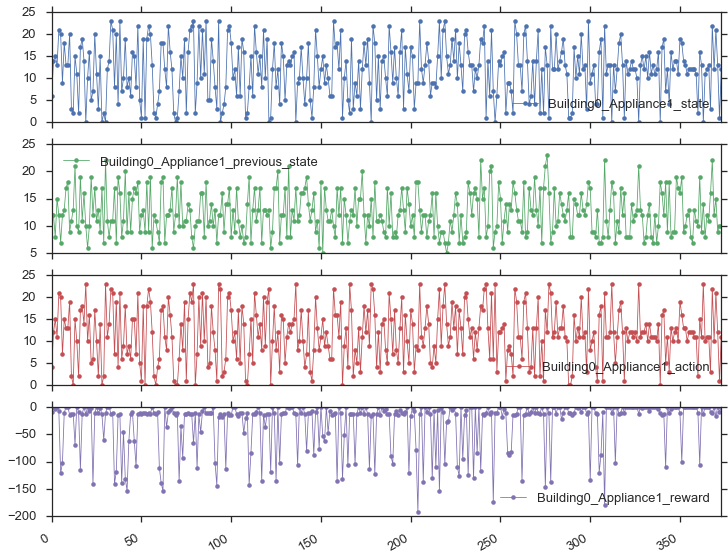

In [80]:
action.ix[:,['Building0_Appliance1_state',
          'Building0_Appliance1_previous_state',
          'Building0_Appliance1_action',
          'Building0_Appliance1_reward']].plot(subplots=True, sharex=True, figsize=(12,10), lw=0.8, style='.-')
figure1 = plt.gcf()

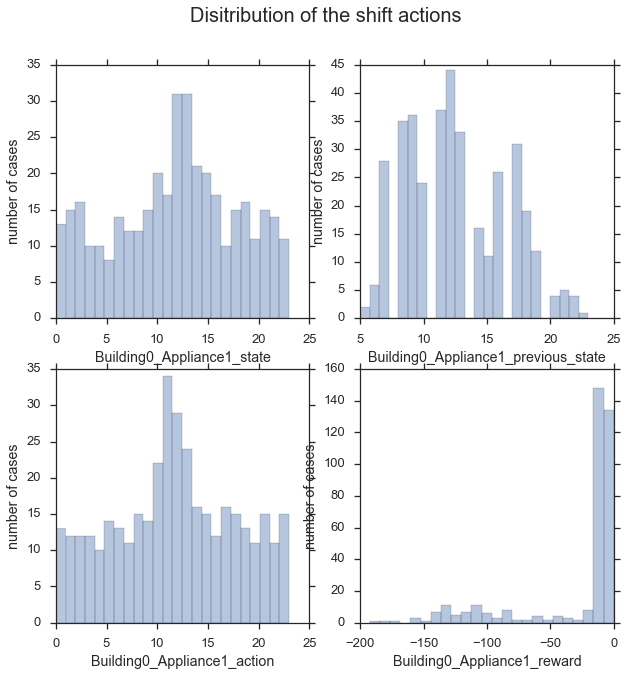

In [94]:
figure11,axn = plt.subplots(2,2,  figsize = (10,10))
for k, col in enumerate(action.ix[:,['Building0_Appliance1_state',
          'Building0_Appliance1_previous_state',
          'Building0_Appliance1_action',
          'Building0_Appliance1_reward']]):
    sns.distplot(action[col],kde=False, bins = 24, ax = axn[k//2,k%2])
    axn[k//2,k%2].set_ylabel('number of cases')
figure11.suptitle('Disitribution of the shift actions',fontsize = 20)

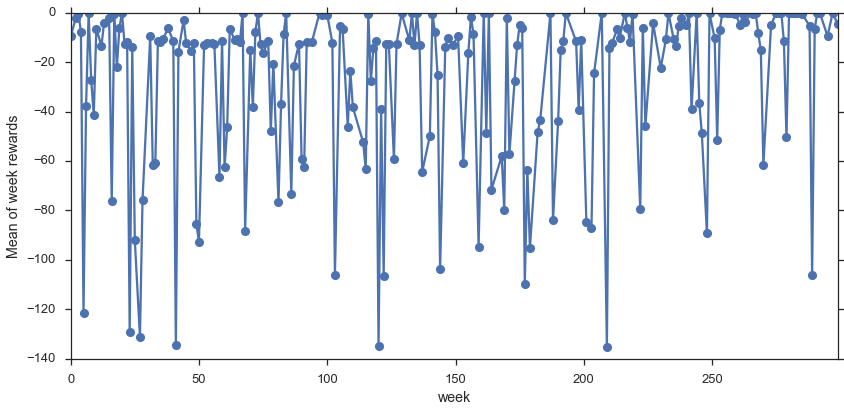

In [95]:
figure2 = plt.figure()
action.groupby('nsim').mean()['Building0_Appliance1_reward'].plot(style = 'o-',figsize=(12,6))
plt.xlabel('week')
plt.ylabel('Mean of week rewards')
plt.tight_layout()

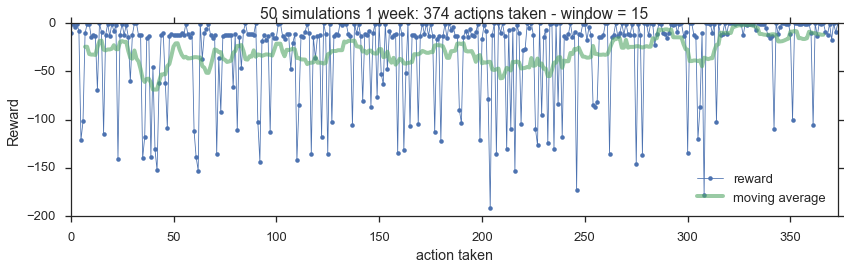

In [96]:
figure3 = plt.figure()
win = 15
action['reward_roll'] = action.Building0_Appliance1_reward.rolling(window=win, center=True).mean()
action['Building0_Appliance1_reward'].plot(lw=0.8,style='.-', figsize = (12,4),label='reward')

action.reward_roll.plot(lw=4., alpha=0.6,label='moving average')
plt.ylabel('Reward')
plt.xlabel('action taken')
plt.legend(loc = 4)
plt.title('50 simulations 1 week: %i actions taken - window = %i'%(actions_taken, win))
plt.tight_layout()

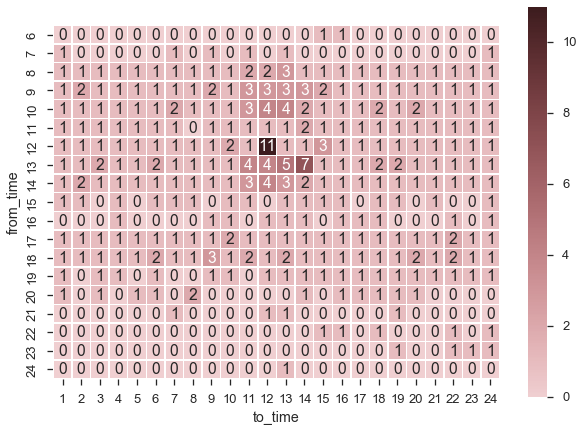

In [91]:
matrix_shifts =action.groupby(by=['Building0_Appliance1_previous_state','Building0_Appliance1_action']).size()

cmap = sns.cubehelix_palette(15, start=0.9, rot=0., as_cmap=True)
matrix_shifts =pd.DataFrame(matrix_shifts.reset_index())
matrix_shifts.columns = ['from_time', 'to_time', 'ntimes']

# sns.set()
figure31 = plt.figure(figsize=(10,10))
matrix_s = matrix_shifts.pivot("from_time", "to_time", "ntimes").fillna(0)

vmin, vmax = matrix_s.values.min(), matrix_s.values.max()
sns.heatmap(matrix_s,  vmin=vmin, vmax=vmax,
            annot = True, linewidths=.5, cbar_kws={"shrink": .7},
            cmap=cmap,square=True,
            xticklabels = range(1,25), yticklabels=range(1,25))

In [92]:
gr = ad.groupby('nsim')
cost_beginning = gr.Building0_Appliance1_cost.sum()[:5].mean()
cost_end = gr.Building0_Appliance1_cost.sum()[-5:].mean()
cost_reduction = (cost_beginning - cost_end)/cost_beginning
cost_reduction * 100

-8.752882693229527

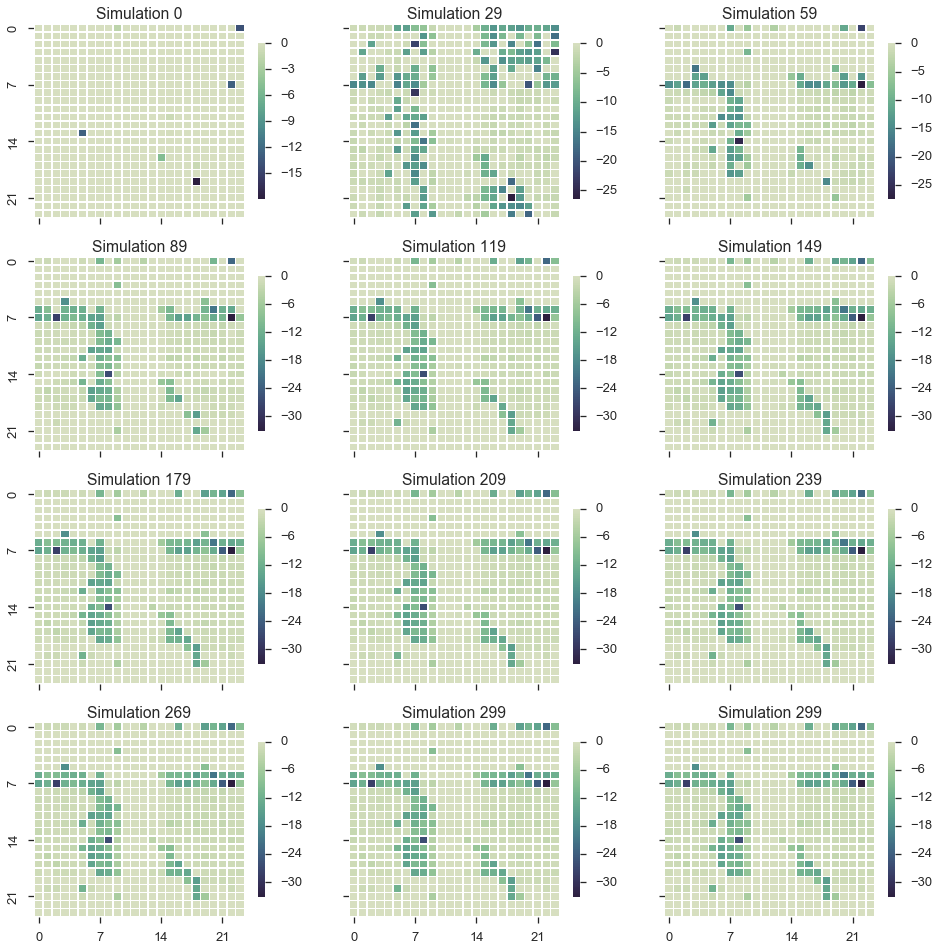

In [93]:
number_of_simulations = nomassLearn.numberOfSimulations -1

cmap = sns.cubehelix_palette(100, start=.5, rot=-.75, as_cmap=True, reverse=True)
how_many_to_plot = 10  #15 or 50
figure5,axn = plt.subplots(how_many_to_plot//3+1, 3, sharex=True, sharey=True,
                       figsize = (16,4*(how_many_to_plot//3 +1)))

for j,ax in enumerate(axn.flat[:number_of_simulations]):
    j=j*number_of_simulations/how_many_to_plot # so that we only take every 3 simulations
    if j < number_of_simulations: pass
    else: j = number_of_simulations
    dat = pd.read_csv(nomassLearn.resultsLocation + '/Building0_Appliance6_6.dat.%.5i'%j,header=None,usecols=range(24))
    vmaj = dat.values.min()
    sns.heatmap(dat, cmap=cmap, square=False, xticklabels=7, yticklabels=7,
            linewidths=.5, cbar_kws={"shrink": .8}, ax=ax,vmin=vmaj)
    ax.set_title('Simulation %i'%j)
#     vmin= dat.values.min()
    if j==number_of_simulations : vmaj = dat.values.min()
# vmaj = vmin

### Have Nomass simulate a base case data

Simulate a base case for comparison

In [58]:
basecase = NoMASS()
basecase.runLocation = "../FMU/build/Simulation/"
basecase.locationOfNoMASS = "../FMU/build/"
basecase.configurationDirectory = home +"/git/No-MASSDSM/Configuration/Experiment4/"

basecase.resultsLocation = "../FMU/build/ResultsBaseCase/"
basecase.PVFile = "PV_single_profile.csv"
basecase.printInput = True
basecase.PandasFiles = True
basecase.numberOfSimulations = 50['Building0_Appliance1_state',
          'Building0_Appliance1_previous_state',
          'Building0_Appliance1_action',
          'Building0_Appliance1_reward']

In [59]:
basecase.simulate()

Run location: ../FMU/build/Simulation/
locationOfNoMASS: ../FMU/build/
configurationDirectory: /Users/jake/git/No-MASSDSM/Configuration/Experiment4/
resultsLocation: ../FMU/build/ResultsBaseCase/
printInput: True
numberOfSimulations: 50
Learning: False
Number of agents 2
Number of large appliances 1
Number of small appliances 0
Number of pv appliances 1
Simulation: 1 Time: 00 seconds
Simulation: 26 Time: 17 seconds


### Have Nomass simulate useing the learnt data

Using the learnt data simulate some resutls for comparison
set epsilon to 0 so no randomness takes place
set learn to false so no longer updates the learning q-table
set learntData to the location of the learnt values

In [60]:
nomass = NoMASS()
nomass.runLocation = "../FMU/build/Simulation/"
nomass.locationOfNoMASS = "../FMU/build/"
nomass.configurationDirectory = home +"/git/No-MASSDSM/Configuration/Experiment3/"

nomass.resultsLocation = "../FMU/build/ResultsLearnt/"
nomass.PVFile = "PV_single_profile.csv"
nomass.printInput = True
nomass.PandasFiles = True
nomass.numberOfSimulations = 50
nomass.epsilon = 0.0
nomass.learn = False
nomass.learntData = nomassLearn.learntDataLocation()

In [61]:
nomass.simulate()

Run location: ../FMU/build/Simulation/
locationOfNoMASS: ../FMU/build/
configurationDirectory: /Users/jake/git/No-MASSDSM/Configuration/Experiment3/
resultsLocation: ../FMU/build/ResultsLearnt/
printInput: True
numberOfSimulations: 50
Learning: False
Number of agents 2
Number of large appliances 0
Number of small appliances 0
Number of pv appliances 1
Simulation: 1 Time: 00 seconds
Simulation: 26 Time: 17 seconds


In [62]:
basecase_ad = pd.read_hdf(basecase.resultsLocation + 'NoMASS.out.hdf','NoMass')
basecase_ad_nodr = basecase_ad[['Building0_Appliance1_requested',
          'Building0_Appliance1_recieved',
          'Building0_Appliance1_cost',
          'Building0_Appliance1_suppliedCost',
          'nsim']]

ad = pd.read_hdf(nomass.resultsLocation + 'NoMASS.out.hdf','NoMass')
ad_nodr = ad[['Building0_Appliance1_requested',
          'Building0_Appliance1_recieved',
          'Building0_Appliance1_cost',
          'Building0_Appliance1_suppliedCost',
          'nsim']]

print basecase_ad.TimeStep.dropna().shape[0]/1440.
print ad.TimeStep.dropna().shape[0]/1440.

350.0
350.0


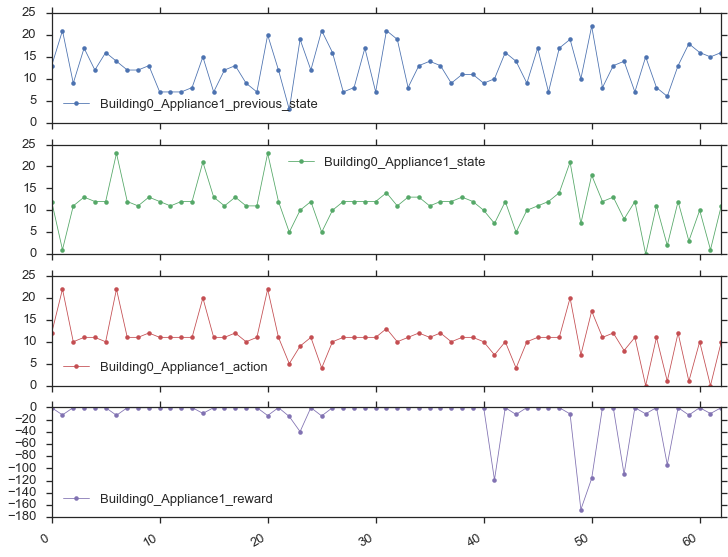

In [63]:
action = ad[[col for col in list(ad) if (col.startswith('Building0_Appliance1_') or col=='nsim')]]
action = action.dropna().reset_index(drop=True)
action.ix[:,[9,5,6,7]].plot(subplots=True, sharex=True, figsize=(12,10), lw=0.8, style='.-')
figure1 = plt.gcf()

In [64]:
weekly_cost = ad_nodr.groupby(by='nsim').Building0_Appliance1_cost.sum()
weekly_poweruse = ad_nodr.groupby(by='nsim').Building0_Appliance1_recieved.sum()
weekly_cost_b = basecase_ad_nodr.groupby(by='nsim').Building0_Appliance1_cost.sum()
weekly_poweruse_b = basecase_ad_nodr.groupby(by='nsim').Building0_Appliance1_recieved.sum()

weekly_df = pd.DataFrame({'Learnt Cost': weekly_cost, 'Base Cost': weekly_cost_b, 'Learnt Power': weekly_poweruse, 'Base Power': weekly_poweruse_b})


print(np.median(weekly_cost))
print(np.median(weekly_cost_b))

23.96503075
5059.31525425


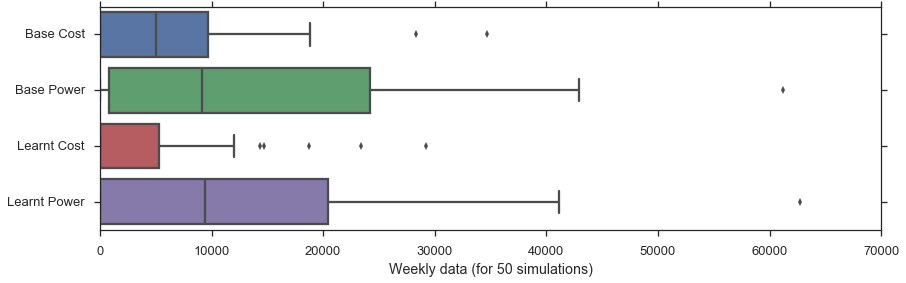

In [65]:
fig1=plt.figure(figsize = (14,4))
sns.boxplot(data=weekly_df, orient = 'h')
plt.xlabel('Weekly data (for 50 simulations)')


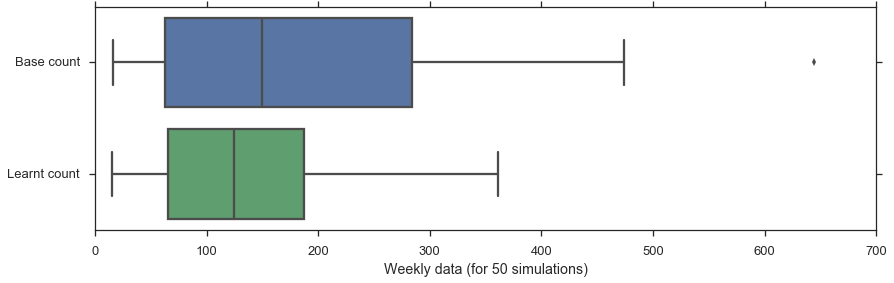

In [46]:
weekly_count = ad[ad.Building0_Appliance1_recieved > 0].groupby(by='nsim').Building0_Appliance1_recieved.count()
weekly_count_b = basecase_ad[basecase_ad.Building0_Appliance1_recieved > 0].groupby(by='nsim').Building0_Appliance1_recieved.count()

weekly_df_count = pd.DataFrame({'Learnt count': weekly_count, 'Base count': weekly_count_b})


fig1=plt.figure(figsize = (14,4))
sns.boxplot(data=weekly_df_count, orient = 'h')
plt.xlabel('Weekly data (for 50 simulations)')

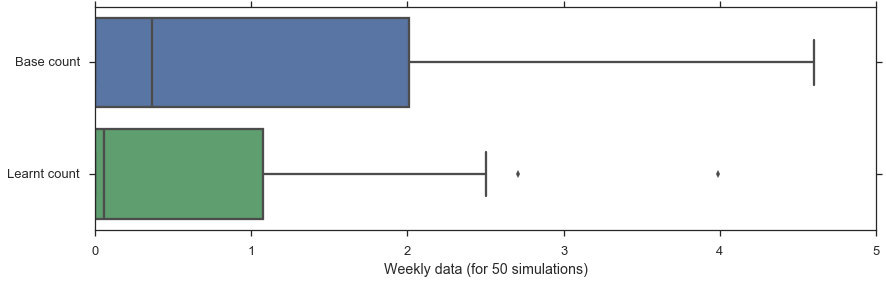

In [47]:
weekly_count = ad.groupby(by='nsim').Building0_Appliance1_cost.mean()
weekly_count_b = basecase_ad.groupby(by='nsim').Building0_Appliance1_cost.mean()

weekly_df_count = pd.DataFrame({'Learnt count': weekly_count, 'Base count': weekly_count_b})


fig1=plt.figure(figsize = (14,4))
sns.boxplot(data=weekly_df_count, orient = 'h')
plt.xlabel('Weekly data (for 50 simulations)')